In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

c:\Users\jacks\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Importing data

In [2]:
data = pd.read_csv('../data/accre-gpu-jobs-2022-v2.csv', on_bad_lines='skip')

Filtering data for jobs that are completed and used > 0 MB of Memory

In [3]:
#Only include jobs that have been completed, 'STATE' = COMPLETED
#Exclude jobs with memory usage = 0 Mb
data = (data[
    (data['STATE']=='COMPLETED') & 
    (data['USEDMEM']!='0') &
    (data['USEDMEM']!='0.00M')
    ])

Function to convert the time strings in the data into second integers for calculations.

In [4]:
def str2seconds(timestr):
    if len(timestr) == 8:
        # split in hh, mm, ss
        hh, mm, ss = timestr.split(':')
        return int(hh) * 3600 + int(mm) * 60 + int(ss)
    else:
        d = timestr[0]
        dropday = timestr[2:]
        hh, mm, ss = dropday.split(':')
        return int(d) *3600*24 + int(hh) * 3600 + int(mm) * 60 + int(ss)

Converting the used time and requested time columns into second values.

In [5]:
#First take times and convert to seconds
usedtime = data['USEDTIME']
reqtime = data['REQTIME']
usedtime_seconds = []
reqtime_seconds = []

for string in usedtime:
    usedtime_seconds.append(str2seconds(string))

for string in reqtime:
    reqtime_seconds.append(str2seconds(string))

Converting the used memory column into a float, stripping the preciding "M" in the string values.

In [6]:
data['USEDMEM'] = data['USEDMEM'].str.strip('M').astype(float)

Adding back the time in seconds columns, also adding a time weighted used memory per GPU used on each job

In [7]:
data['req_time_seconds'] = reqtime_seconds
data['used_time_seconds'] = usedtime_seconds

#Get used memory per GPU for each job 
data['USEDMEM_per_GPU'] = data['USEDMEM']/data['GPUS']
#Weight the used memory based on amount of time the request was 
data['weighted_used_mem'] = (data['USEDMEM_per_GPU']*data['used_time_seconds'])/sum(usedtime_seconds)

Seperating data into the different partitions. 

In [8]:
#Group by partition name for seperate analysis if needed
turing = data[data['PARTITION'] == 'turing']
maxwell = data[data['PARTITION'] == 'maxwell']
pascal = data[data['PARTITION'] == 'pascal']

# Question 1
What is the distribution of per-GPU main memory usage over all runtime-weighed jobs in each partition? Knowing this will help ACCRE to understand our users memory needs for future hardware purchases.

Initial histogram of the number of jobs used in each partitition and how much memory they used.

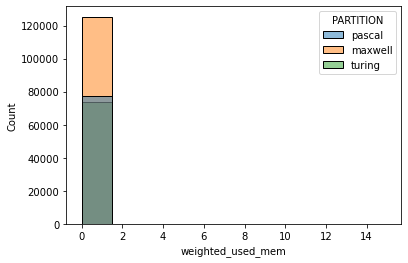

In [9]:
sns.histplot(x = data['weighted_used_mem'], hue = data['PARTITION'], bins = 10)
plt.show()

Skewed Data - 
This dataset is extremely skewed so lets set the axes to log scale. 

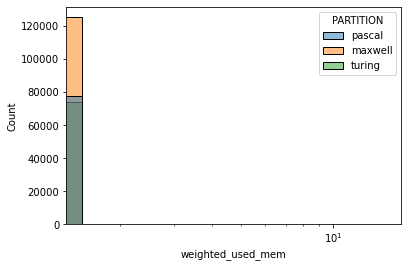

In [10]:
histogram = sns.histplot(x = data['weighted_used_mem'], hue = data['PARTITION'], bins = 10)
histogram.set(xscale='log')
plt.show()

We can see that that the histogram is still the same so lets look at the box plot and CDF represenatations of the data to get a closer picture of each of the partitions. 

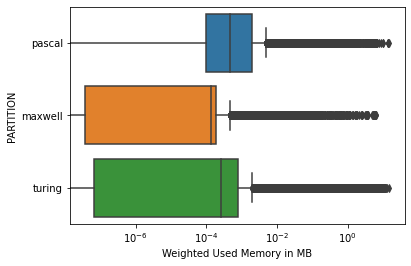

In [11]:
boxplot = sns.boxplot(x = data['weighted_used_mem'], y = data['PARTITION'])
boxplot.set(xscale= 'log')
boxplot.set(xlabel = 'Weighted Used Memory in MB')
plt.show()

In [12]:
data['weighted_used_mem'].groupby(data['PARTITION']).describe()

,count,mean,std,min,25%,50%,75%,max
PARTITION,,,,,,,,
maxwell,125370.0,0.002595,0.068776,0.0,3.721905e-08,0.000131,0.000186,6.152163
pascal,77769.0,0.018569,0.205759,0.0,1.008850e-04,0.000460,0.001988,14.197097
turing,74336.0,0.043253,0.412154,0.0,6.504556e-08,0.000263,0.000803,14.952076


We can see that each of the partitions have very simliar medians for amount of data used per GPU.   

In [13]:
#Lets look at the number of outliers for each of the partition distributions
df_quant = data.pivot(values=['weighted_used_mem'], columns=['PARTITION'])
Q1 = df_quant.quantile(0.25)
Q3 = df_quant.quantile(0.75)
IQR = Q3 - Q1

Extreme Outliers

In [14]:
Q3 + 3* IQR

                   PARTITION
weighted_used_mem  maxwell      0.000743
                   pascal       0.007648
                   turing       0.003212
dtype: float64

In [15]:
#Calculate the percentage of number of outliers to the total number of jobs in that distribution
# outliers = ((df_quant < (Q1 - 1.5 * IQR)) | (df_quant > (Q3 + 1.5 * IQR))).sum()
outliers = (df_quant>(Q3 + 3 * IQR)).sum()
print('The number of outliers for each of the partitions:\n', outliers)
percentage_outliers = outliers/[len(maxwell), len(pascal), len(turing)]
print('The percentage of extreme outliers to total number of jobs per partition:\n', percentage_outliers)


The number of outliers for each of the partitions:
                    PARTITION
weighted_used_mem  maxwell       9520
                   pascal       15702
                   turing       13742
dtype: int64
The percentage of extreme outliers to total number of jobs per partition:
                    PARTITION
weighted_used_mem  maxwell      0.075935
                   pascal       0.201906
                   turing       0.184863
dtype: float64


CDF plot for the weighted used memory in each partition. 

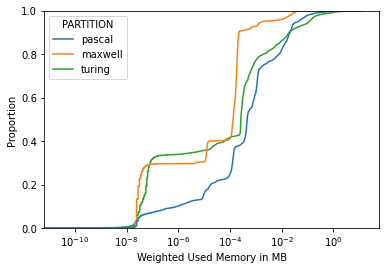

In [16]:
cdf_plot = sns.ecdfplot(x = data['weighted_used_mem'], hue = data['PARTITION'])
cdf_plot.set(xscale= 'log')
cdf_plot.set(xlabel = 'Weighted Used Memory in MB')
plt.show()

# Question 2 
What is the distribution of the number of GPUs in each job (runtime-weighted) for each partition? What fraction of runtime-weighted and GPU-weighted jobs are using more than 4 GPUs and thus probably using the RoCE networking? Is this fraction different for each partition?

In [17]:
data['weighted_num_GPUs'] = (data['GPUS']*data['used_time_seconds'])/sum(usedtime_seconds)

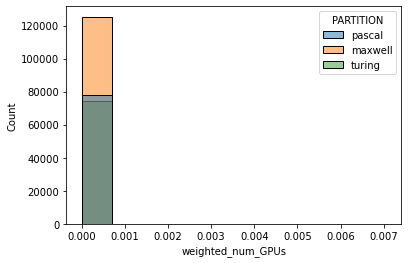

In [18]:
histogram_2 = sns.histplot(x = data['weighted_num_GPUs'], hue = data['PARTITION'], bins = 10)

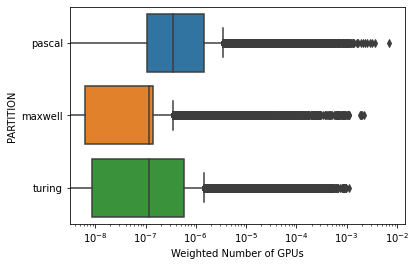

In [19]:
boxplot_2 = sns.boxplot(x = data['weighted_num_GPUs'], y = data['PARTITION'])
boxplot_2.set(xscale= 'log')
boxplot_2.set(xlabel='Weighted Number of GPUs')
plt.show()

Proportion of jobs that used greater than 4 GPUS, aka an RoCE machine 

In [20]:
df_RoCE = data[data['GPUS']>4]

Proprtion for all jobs that have greater than 4 GPUs

In [21]:
prop_RoCE = len(df_RoCE)/len(data)
prop_RoCE

0.0031894765294170646

This is the breakdown of proportions of jobs that use the RoCE networking for each partition

In [22]:
df_RoCE_partitions = df_RoCE.pivot(values = 'GPUS', columns= 'PARTITION').notna().sum()/[len(maxwell), len(pascal), len(turing)]
df_RoCE_partitions

PARTITION
maxwell    0.002122
pascal     0.005696
turing     0.002368
dtype: float64

Bar Chart for all 4 values above:

In [23]:
partition_series = pd.Series(['maxwell', 'pascal', 'turing', 'All partitions'])
value_series = pd.Series([df_RoCE_partitions[0], df_RoCE_partitions[1], df_RoCE_partitions[2], prop_RoCE])
frame = {'Partition':partition_series, 'Proportion of RoCE Jobs':value_series}
bar_chart_Q2_df = pd.DataFrame(frame)

[(0.0, 0.025)]

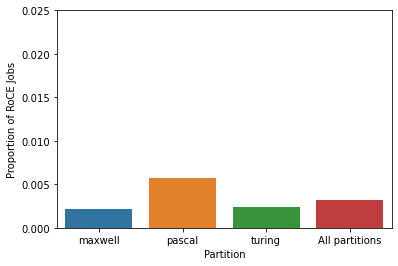

In [24]:
barplot_1 = sns.barplot(data = bar_chart_Q2_df, x = 'Partition', y = 'Proportion of RoCE Jobs')
barplot_1.set(ylim=[0,.025])


# Question 3 
What is the total runtime usage per-gpu (i.e. multiply runtime by the number of gpus) in each of the 3 partitions over the last year?

In [25]:
data['gpu_runtime_total_seconds'] = data['GPUS']*data['used_time_seconds']

Total GPU time usage on each of the partitions in years:

In [26]:
data.groupby('PARTITION')['gpu_runtime_total_seconds'].sum()/(365*24*60*60)
d = {'Partition':['maxwell', 'pascal', 'turing'], 'Total Runtime in Years': data.groupby('PARTITION')['gpu_runtime_total_seconds'].sum()/(365*24*60*60)}
barplot_2_data = pd.DataFrame(data=d)

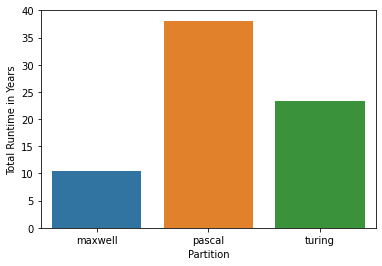

In [27]:
barplot_2 = sns.barplot(data=barplot_2_data, x = 'Partition', y = 'Total Runtime in Years')

# Question 4 
What is the distribution of different groups and users accessing each partition? In each partition, who are the top users, and do they represent a majority of the runtime-weighted jobs on the partition?

First filter the data with only regular jobs to get rid of array request which could throw off the actual top users

In [28]:
from numpy import NaN

non_array_jobs = []
for index, row in data.iterrows():
    if len(row["JOBID"]) == 8: #Length of Job ID for non array job is = 8
        non_array_jobs.append(index)
    else:
        non_array_jobs.append(NaN)


In [29]:
data_non_array_jobs = data[data.index == non_array_jobs]

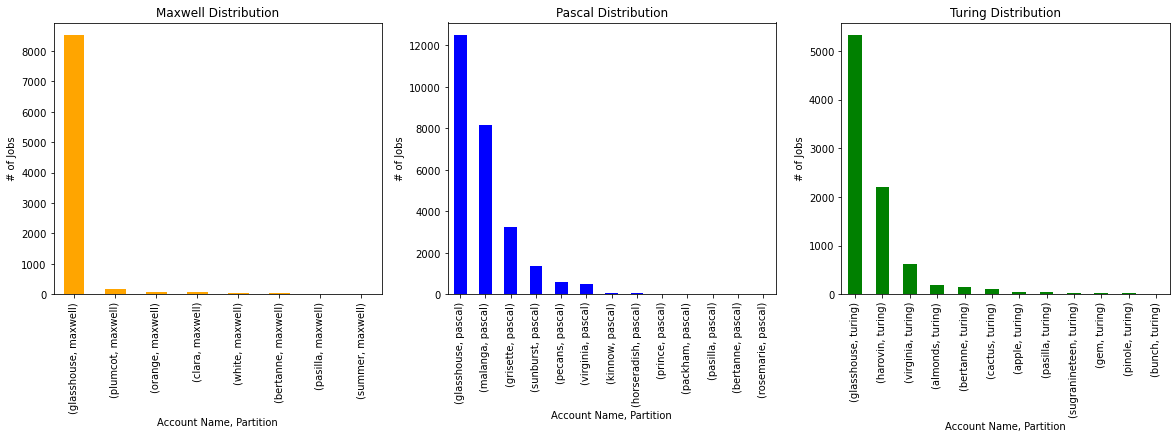

In [40]:
from matplotlib.pyplot import figure

maxwell_non_arr = data_non_array_jobs[['ACCOUNT','PARTITION']].groupby('PARTITION').get_group('maxwell').value_counts()
pascal_non_arr = data_non_array_jobs[['ACCOUNT','PARTITION']].groupby('PARTITION').get_group('pascal').value_counts()
turing_non_arr = data_non_array_jobs[['ACCOUNT','PARTITION']].groupby('PARTITION').get_group('turing').value_counts()


figure(figsize = (20,5))

plt.subplot(1,3,1)
maxwell_non_arr.plot(kind = 'bar', color = 'orange')
plt.title('Maxwell Distribution')
plt.xlabel('Account Name, Partition')
plt.ylabel('# of Jobs')

plt.subplot(1,3,2)
pascal_non_arr.plot(kind = 'bar', color = 'blue')
plt.title('Pascal Distribution')
plt.xlabel('Account Name, Partition')
plt.ylabel('# of Jobs')

plt.subplot(1,3,3)
turing_non_arr.plot(kind = 'bar', color = 'green')
plt.title('Turing Distribution')
plt.xlabel('Account Name, Partition')
plt.ylabel('# of Jobs')

plt.show()

# Question 5 
Currently there is a 5 day limit on runtime for GPU jobs, although some users have been asking for extensions. What is the distribution of requested runtime and actual runtime on jobs on each partition? Do users really need more time, or are they simply always requesting the maximum?

In [32]:
data_non_array_jobs.loc[:,'reqtime_days'] = data_non_array_jobs['req_time_seconds'] / 86400
data_non_array_jobs.loc[:,'usedtime_days'] = data_non_array_jobs['used_time_seconds'] / 86400
data_non_array_jobs.loc[:,'reqtime_usedtime_days_diff'] = data_non_array_jobs['reqtime_days'] - data_non_array_jobs['usedtime_days']

C:\Users\jacks\AppData\Local\Temp\ipykernel_22736\1428855172.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_non_array_jobs.loc[:,'reqtime_days'] = data_non_array_jobs['req_time_seconds'] / 86400
C:\Users\jacks\AppData\Local\Temp\ipykernel_22736\1428855172.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_non_array_jobs.loc[:,'usedtime_days'] = data_non_array_jobs['used_time_seconds'] / 86400
C:\Users\jacks\AppData\Local\Temp\ipykernel_22736\1428855172.py:3: SettingWithCopyWarning: 
A value 

In [35]:
maxwell_data_5 = data_non_array_jobs[['ACCOUNT','PARTITION', 'reqtime_usedtime_days_diff']].groupby('PARTITION').get_group('maxwell')
pascal_data_5 = data_non_array_jobs[['ACCOUNT','PARTITION', 'reqtime_usedtime_days_diff']].groupby('PARTITION').get_group('pascal')
turing_data_5 = data_non_array_jobs[['ACCOUNT','PARTITION', 'reqtime_usedtime_days_diff']].groupby('PARTITION').get_group('turing')

Text(0.5, 0, 'Account Name')

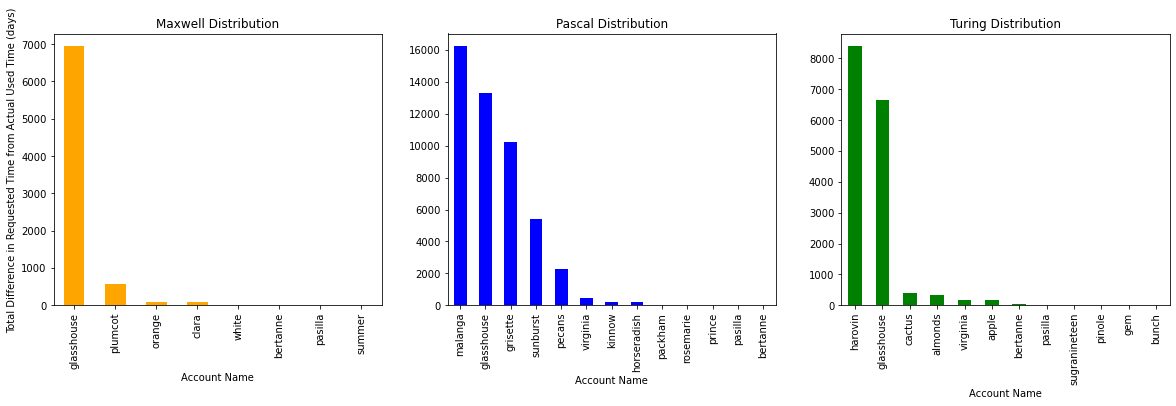

In [43]:
mplot = maxwell_data_5.groupby('ACCOUNT')['reqtime_usedtime_days_diff'].sum().sort_values(ascending=False)
pplot = pascal_data_5.groupby('ACCOUNT')['reqtime_usedtime_days_diff'].sum().sort_values(ascending=False)
tplot = turing_data_5.groupby('ACCOUNT')['reqtime_usedtime_days_diff'].sum().sort_values(ascending=False)


figure(figsize = (20,5))

plt.subplot(1,3,1)
mplot.plot(kind = 'bar', color = 'orange')
plt.title('Maxwell Distribution')
plt.xlabel('Account Name')
plt.ylabel('Total Difference in Requested Time from Actual Used Time (days)')

plt.subplot(1,3,2)
pplot.plot(kind = 'bar', color = 'blue')
plt.title('Pascal Distribution')
plt.xlabel('Account Name')


plt.subplot(1,3,3)
tplot.plot(kind = 'bar', color = 'green')
plt.title('Turing Distribution')
plt.xlabel('Account Name')
